In [29]:

from song_handler import Song
import soundfile as sf
import librosa
import numpy as np
import os
from utils import Graph, fadeout_cur_fadein_next, get_partial_audio
from utils import show_dtw_cost_matrix_and_wp  # for debug
import matplotlib.pyplot as plt

FULL_WINDOW_SECONDS = 45
WINDOW_SIZE_SAMPLES_PREFIX = 100
WINDOW_SIZE_SAMPLES_SUFFIX = 200
FADE_DURATION = 2.0

np_files_path = "numpy_arrays\\playlister_outputs"
cut_indices_prefix = np.load(os.path.join(np_files_path, "cut_indices_prefix_window_100_hop_25.npy"))
cut_indices_suffix = np.load(os.path.join(np_files_path, "cut_indices_suffix_window_200_hop_25.npy"))
playlister_playlist_numpy = np.load(os.path.join(np_files_path, "playlister_playlist_numpy.npy"))
playlister_playlist_fader_numpy = np.load(os.path.join(np_files_path, "playlister_playlist_fader_numpy.npy"))
songs_name_order = np.load(os.path.join(np_files_path, "songs_name_order.npy"))
adjecency_matrix = np.load(os.path.join(np_files_path, "adjacency_matrix.npy"))
music_dir = "playlist"
songs_file_names_list = os.listdir(music_dir)

order_songs_list = []
for song_prefix_name in songs_name_order:
    for song_name in songs_file_names_list:
        if song_prefix_name == song_name.split(".")[0]:
            song = Song(os.path.join(music_dir, song_name))
            order_songs_list.append(song)
            break

print([song.song_name for song in order_songs_list])


number_of_songs = len(order_songs_list)
songs_time_len_after_cut = []
songs_start_secs = []
songs_end_secs = []
for i in range(number_of_songs):
    start_sec = 0 if i == 0 else cut_indices_prefix[i-1, i]*0.02
    end_sec = 0 if i == number_of_songs-1 else - FULL_WINDOW_SECONDS + \
                                                    (cut_indices_suffix[i, i+1] +
                                                    WINDOW_SIZE_SAMPLES_SUFFIX) * 0.02
    end_sec = len(order_songs_list[i].audio)/order_songs_list[i].sr + end_sec
    song_time_after_cut = end_sec - start_sec
    songs_start_secs.append(start_sec)
    songs_end_secs.append(end_sec)
    songs_time_len_after_cut.append(song_time_after_cut)

full_audio_transition_times = np.cumsum(songs_time_len_after_cut)
print(full_audio_transition_times)

['Ariana Grande - 7 rings', 'Daddy Yankee - Dura', 'Calvin Harris, Dua Lipa - One Kiss', 'The Black Eyed Peas - Where Is The Love_ my-free-mp3s', 'Dr', 'Ozuna, Daddy Yankee, J Balvin feat', 'Jay-Z, Linkin Park - Numb _ Encore my-free-mp3s', 'KONGOS - Come with Me Now', 'Bruno Mars - 24K Magic myfreemp3', 'Cardi B, Bad Bunny, J Balvin - I Like It']
[ 160.64        314.78708333  497.14204167  697.175375    857.84133333
 1033.3759375  1215.1559375  1371.4115625  1538.47679167 1782.36708333]


In [30]:
# songs_start_secs = [t[0] if not isinstance(t,int) else t for t in songs_start_secs]
# songs_end_secs = [t[0] if not isinstance(t,float) else t for t in songs_end_secs]
print(songs_start_secs)
print(songs_end_secs)

[0, 21.5, 17.0, 40.5, 13.0, 26.0, 0.5, 37.0, 24.0, 9.5]
[160.64, 175.64708333333334, 199.35495833333334, 240.53333333333336, 173.66595833333332, 201.53460416666667, 182.28, 193.255625, 191.06522916666665, 253.39029166666666]


suffix beat track
tempo : 140.625
beats (frame) : [ 14  55  95 134 175 215 256 296 336 373]
beats (sec) : [0.15 0.59 1.01 1.43 1.87 2.29 2.73 3.16 3.58 3.98]


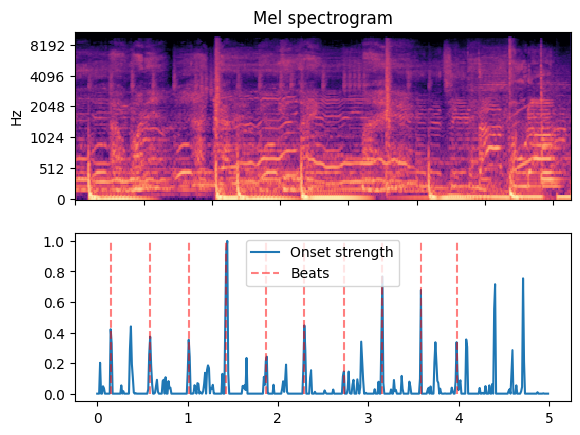

prefix beat track
tempo : 187.5
beats (frame) : [ 42  71 102 131 161 190 220 249 279 309 338 368 398 427]
beats (sec) : [0.45 0.76 1.09 1.4  1.72 2.03 2.35 2.66 2.98 3.3  3.61 3.93 4.25 4.55]


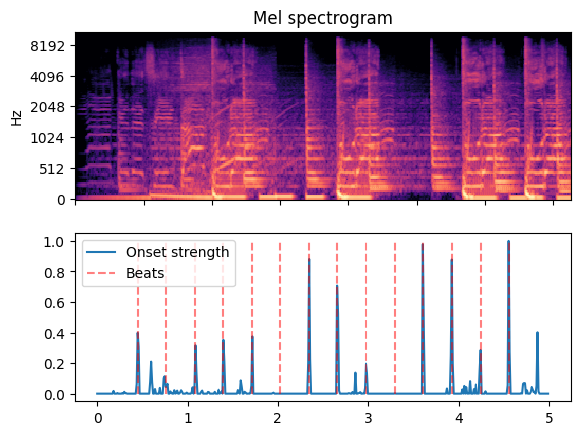

transition beat track
tempo : 95.33898305084746
beats (frame) : [ 74 134 195 256 317 383 442 511 571 630 689 748 807 866]
beats (sec) : [0.79 1.43 2.08 2.73 3.38 4.09 4.71 5.45 6.09 6.72 7.35 7.98 8.61 9.24]


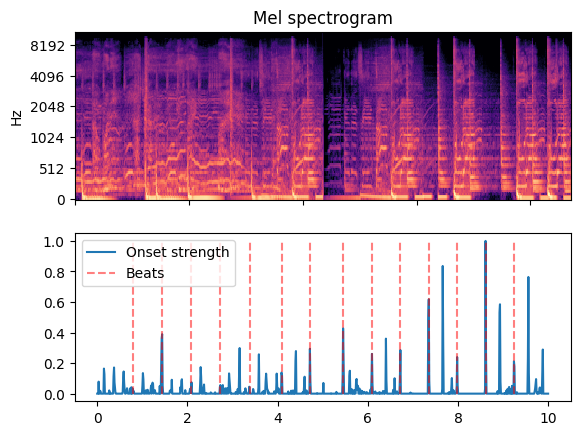

In [57]:
def plot_beat_track(audio, sr, xlim):
    # credits to https://librosa.org/doc/0.10.2/generated/librosa.beat.beat_track.html
    y = audio
    onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
                                           sr=sr)
    print(f"tempo : {tempo}")
    print(f"beats (frame) : {beats}")
    print(f"beats (sec) : {librosa.frames_to_time(beats, sr=sr).round(2)}")
    hop_length = 512
    fig, ax = plt.subplots(nrows=2)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time', hop_length=hop_length,
                             ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram')
    ax[1].plot(times, librosa.util.normalize(onset_env),
             label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r',
               linestyle='--', label='Beats')
    ax[1].legend()
    plt.xlim = xlim
    plt.show()

window = 5
idx1, idx2 = 0, 1
sr = order_songs_list[0].sr
songs_start_secs = np.array(songs_start_secs)
songs_end_secs = np.array(songs_end_secs)
suffix_song1 = order_songs_list[idx1].get_partial_audio(start_sec=songs_end_secs[idx1]-window,
                                                        end_sec=songs_end_secs[idx1])
prefix_song2 = order_songs_list[idx2].get_partial_audio(start_sec=songs_start_secs[idx2],
                                                        end_sec=songs_start_secs[idx2]+window)
# concat_song_fader = fadeout_cur_fadein_next(suffix_song1, prefix_song2, sr, duration=FADE_DURATION)
concat_song = np.concatenate([suffix_song1, prefix_song2])
print("suffix beat track")
plot_beat_track(suffix_song1, sr, [0, window])
print("prefix beat track")
plot_beat_track(prefix_song2, sr, [0, window])
print("transition beat track")
# plot_beat_track(concat_song_fader, sr, [0, 2*window-FADE_DURATION])
plot_beat_track(concat_song, sr, [0, window*2])

In [52]:
def check_beat_distance_between_two_audio(audio1, audio2, sr):
    onset_env1 = librosa.onset.onset_strength(y=audio1, sr=sr,
                                         aggregate=np.median)
    tempo1, beats1 = librosa.beat.beat_track(onset_envelope=onset_env1,
                                           sr=sr)

    onset_env2 = librosa.onset.onset_strength(y=audio2, sr=sr,
                                         aggregate=np.median)
    tempo2, beats2 = librosa.beat.beat_track(onset_envelope=onset_env2,
                                           sr=sr)
    if len(beats1) > len(beats2):
        beats1 = beats1[:len(beats2)]
    else:
        beats2 = beats2[:len(beats1)]
    beats1 = librosa.frames_to_time(beats1)
    beats2 = librosa.frames_to_time(beats2)
    return np.average(abs(beats1 - beats2)), tempo1/tempo2


# Check beat distance for all songs transitions generated by MusicGen based solution:
window = 10
sr = order_songs_list[0].sr
beat_dist_sum_music_gen = 0
tempo_ratio_sum_mucic_gen = 0
for i in range(1, len(order_songs_list)):
    idx1 = i-1
    idx2 = i
    suffix_song1 = order_songs_list[idx1].get_partial_audio(start_sec=songs_end_secs[idx1]-window,
                                                            end_sec=songs_end_secs[idx1])
    prefix_song2 = order_songs_list[idx2].get_partial_audio(start_sec=songs_start_secs[idx2],
                                                            end_sec=songs_start_secs[idx2]+window)
    beat_dist, tempo_ratio = check_beat_distance_between_two_audio(suffix_song1, prefix_song2, sr)
    print(f"check beat distance between suffix {i-1} and prefix {i} ... ")
    print(f"beat_dist : {beat_dist}")
    print(f"tempo ratio : {tempo_ratio}")
    print("==================================================")
    beat_dist_sum_music_gen += beat_dist
    tempo_ratio_sum_mucic_gen += tempo_ratio



check beat distance between suffix 0 and prefix 1 ... 
beat_dist : 4.049560090702948
tempo ratio : 1.4749999999999999
check beat distance between suffix 1 and prefix 2 ... 
beat_dist : 2.315361192095886
tempo ratio : 0.7627118644067796
check beat distance between suffix 2 and prefix 3 ... 
beat_dist : 1.6083688586545728
tempo ratio : 1.3333333333333333
check beat distance between suffix 3 and prefix 4 ... 
beat_dist : 0.28483144368858676
tempo ratio : 1.0166666666666666
check beat distance between suffix 4 and prefix 5 ... 
beat_dist : 3.806524565381708
tempo ratio : 0.6885245901639344
check beat distance between suffix 5 and prefix 6 ... 
beat_dist : 4.114907677356657
tempo ratio : 1.2619047619047619
check beat distance between suffix 6 and prefix 7 ... 
beat_dist : 4.667210884353741
tempo ratio : 1.0188679245283019
check beat distance between suffix 7 and prefix 8 ... 
beat_dist : 0.7938321995464853
tempo ratio : 0.962962962962963
check beat distance between suffix 8 and prefix 9 ...

In [50]:
dtw_np_files_path = "numpy_arrays\\dtw_outputs"
baseline_playlist_np = np.load(os.path.join(dtw_np_files_path, "baseline_playlister_playlist_numpy.npy"))
baseline_song_name_order = np.load(os.path.join(dtw_np_files_path, "baseline_songs_name_order.npy"))
baseline_best_cut_in_sec_tuples = np.load(os.path.join(dtw_np_files_path, "best_cuts_in_sec.npy"))
songs_file_names_list = os.listdir(music_dir)

order_songs_list_dtw = []

for song_prefix_name in baseline_song_name_order:
    for song_name in songs_file_names_list:
        if song_prefix_name == song_name.split(".")[0]:
            song = Song(os.path.join(music_dir, song_name))
            order_songs_list_dtw.append(song)
            break

print([song.song_name for song in order_songs_list_dtw])

number_of_songs_dtw = len(order_songs_list_dtw)
songs_suffix_secs_dtw = []
songs_prefix_secs_dtw = []
songs_time_len_after_cut_dtw = []

for suffix_cut_time, prefix_cut_time in baseline_best_cut_in_sec_tuples:
    songs_suffix_secs_dtw.append(suffix_cut_time)
    songs_prefix_secs_dtw.append(prefix_cut_time)

full_audio_transition_times_dtw = np.cumsum(songs_time_len_after_cut_dtw)
songs_suffix_secs_dtw = np.array(songs_suffix_secs_dtw)
songs_suffix_secs_dtw_real = songs_suffix_secs_dtw[1:] - songs_suffix_secs_dtw[:-1]
songs_suffix_secs_dtw_real = np.concatenate([[songs_suffix_secs_dtw[0]], songs_suffix_secs_dtw_real])
songs_suffix_secs_dtw = np.concatenate([songs_suffix_secs_dtw_real, [len(order_songs_list_dtw[-1].audio)/sr]])
songs_prefix_secs_dtw = np.concatenate([[0], songs_prefix_secs_dtw])


print(songs_suffix_secs_dtw)
print(songs_prefix_secs_dtw)



['Ariana Grande - 7 rings', 'Daddy Yankee - Dura', 'Jay-Z, Linkin Park - Numb _ Encore my-free-mp3s', 'KONGOS - Come with Me Now', 'Dr', 'The Black Eyed Peas - Where Is The Love_ my-free-mp3s', 'Bruno Mars - 24K Magic myfreemp3', 'Calvin Harris, Dua Lipa - One Kiss', 'Cardi B, Bad Bunny, J Balvin - I Like It', 'Ozuna, Daddy Yankee, J Balvin feat']
[165.62933333 138.63095833 161.95291667 125.86929167 130.40625
 220.91366667 182.155875   177.90364583 193.29945833 236.53460417]
[ 0.         40.75733333 38.31466667 42.368      25.73866667 41.84533333
 30.92266667 31.47733333 34.80533333 30.79466667]


In [53]:
# Check beat distance for all songs transitions generated by Baseline based solution:
window = 10
sr = order_songs_list_dtw[0].sr
print("Baseline checking beat distance")
tempo_ratio_sum_baseline = 0
beat_dist_sum_baseline = 0
for i in range(1, len(order_songs_list_dtw)):
    idx1 = i-1
    idx2 = i
    suffix_song1 = order_songs_list_dtw[idx1].get_partial_audio(start_sec=songs_suffix_secs_dtw[idx1]-window,
                                                            end_sec=songs_suffix_secs_dtw[idx1])
    prefix_song2 = order_songs_list_dtw[idx2].get_partial_audio(start_sec=songs_prefix_secs_dtw[idx2],
                                                            end_sec=songs_prefix_secs_dtw[idx2]+window)
    beat_dist, tempo_ratio = check_beat_distance_between_two_audio(suffix_song1, prefix_song2, sr)
    print(f"check beat distance between suffix {i-1} and prefix {i} ... ")
    print(f"beat_dist : {beat_dist}")
    print(f"tempo ratio : {tempo_ratio}")
    print("==================================================")
    tempo_ratio_sum_baseline += tempo_ratio
    beat_dist_sum_baseline += beat_dist

print(f"tempo ratio music gen sum : {tempo_ratio_sum_mucic_gen}")
print(f"tempo ratio dtw baseline sum : {tempo_ratio_sum_baseline}")
print(f"beat dist music gen sum : {beat_dist_sum_music_gen}")
print(f"beat dist dtw baseline sum : {beat_dist_sum_baseline}")

Baseline checking beat distance
check beat distance between suffix 0 and prefix 1 ... 
beat_dist : 2.8359304610733185
tempo ratio : 1.4749999999999999
check beat distance between suffix 1 and prefix 2 ... 
beat_dist : 1.0531908001295756
tempo ratio : 0.8813559322033899
check beat distance between suffix 2 and prefix 3 ... 
beat_dist : 0.4234227024142991
tempo ratio : 1.0384615384615383
check beat distance between suffix 3 and prefix 4 ... 
beat_dist : 1.428920286063143
tempo ratio : 1.1296296296296298
check beat distance between suffix 4 and prefix 5 ... 
beat_dist : 0.24049238743116283
tempo ratio : 0.9836065573770492
check beat distance between suffix 5 and prefix 6 ... 
beat_dist : 0.7925744520030233
tempo ratio : 0.8666666666666667
check beat distance between suffix 6 and prefix 7 ... 
beat_dist : 0.76459993521218
tempo ratio : 0.8490566037735849
check beat distance between suffix 7 and prefix 8 ... 
beat_dist : 0.9636281179138323
tempo ratio : 0.9333333333333335
check beat distanc

suffix beat track
tempo : 140.625
beats (frame) : [109 149 189 230 270 310 350 383 421]
beats (sec) : [1.16 1.59 2.02 2.45 2.88 3.31 3.73 4.09 4.49]


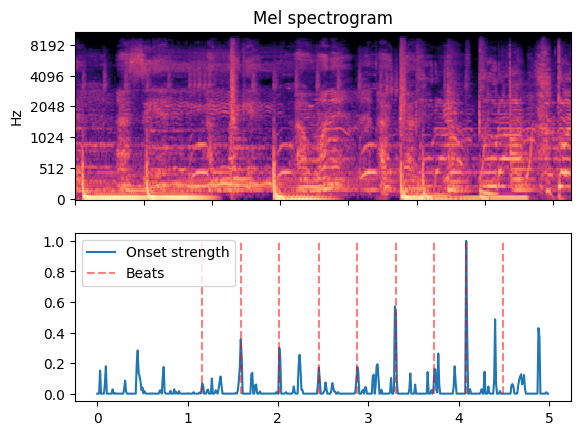

prefix beat track
tempo : 187.5
beats (frame) : [ 13  43  73 102 132 161 191 220 250 280 309 339 369 398 427]
beats (sec) : [0.14 0.46 0.78 1.09 1.41 1.72 2.04 2.35 2.67 2.99 3.3  3.62 3.94 4.25
 4.55]


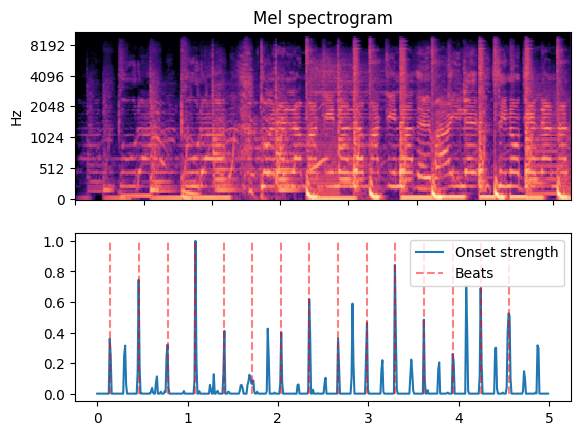

transition beat track
tempo : 187.5
beats (frame) : [ 41  69  96 123 149 180 210 240 270 297 325 354 383 413 447 482 512 541
 571 601 630 660 689 719 748 778 808 838 867 896]
beats (sec) : [0.44 0.74 1.02 1.31 1.59 1.92 2.24 2.56 2.88 3.17 3.47 3.78 4.09 4.41
 4.77 5.14 5.46 5.77 6.09 6.41 6.72 7.04 7.35 7.67 7.98 8.3  8.62 8.94
 9.25 9.56]


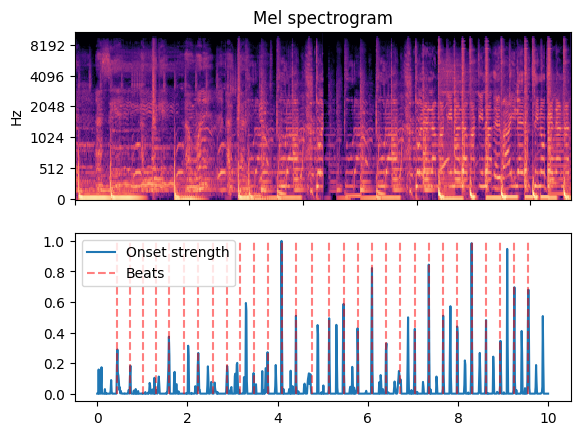

In [55]:
# plot beat track for dtw baseline:

window = 5
idx1, idx2 = 0, 1
sr = order_songs_list_dtw[0].sr

suffix_song1 = order_songs_list_dtw[idx1].get_partial_audio(start_sec=songs_suffix_secs_dtw[idx1]-window,
                                                        end_sec=songs_suffix_secs_dtw[idx1])
prefix_song2 = order_songs_list_dtw[idx2].get_partial_audio(start_sec=songs_prefix_secs_dtw[idx2],
                                                        end_sec=songs_prefix_secs_dtw[idx2]+window)
# concat_song_fader = fadeout_cur_fadein_next(suffix_song1, prefix_song2, sr, duration=FADE_DURATION)
concat_song = np.concatenate([suffix_song1, prefix_song2])

print("suffix beat track")
plot_beat_track(suffix_song1, sr, [0, window])
print("prefix beat track")
plot_beat_track(prefix_song2, sr, [0, window])
print("transition beat track")
# plot_beat_track(concat_song_fader, sr, [0, 2*window-FADE_DURATION])
plot_beat_track(concat_song, sr, [0, 2*window])